Ganymede period T_Ga = 7.1545 days

Resonance               n:m  T_sc (days) a_sc (1e6 km)          e
Initial ~200 d (~28:1) 28:1      200.327        9.869      0.892
20:1                 20:1      143.091        7.886      0.864
14:1                 14:1      100.164        6.217      0.828
10:1                 10:1       71.545        4.968      0.785
7:1                   7:1       50.082        3.917      0.727
5:1                   5:1       35.773        3.130      0.658
3:1                   3:1       21.464        2.226      0.519
Final 2:1             2:1       14.309        1.699      0.370


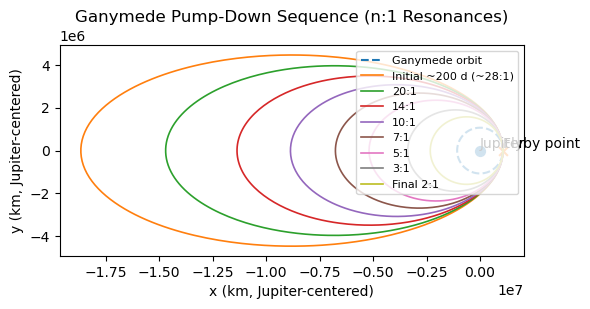

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# 1. Constants
# ----------------------------------------

# Jupiter GM (km^3/s^2) - JPL value
mu_J = 126686531.9

# Ganymede GM and radius (used only if you want v_inf / turning-angle)
mu_G = 9887.83275       # km^3/s^2
R_G  = 2631.20          # km

# Given in problem
a_Ga = 1_070_337.0      # km, Ganymede semi-major axis (assumed circular)

# ----------------------------------------
# 2. Helper functions
# ----------------------------------------

def ganymede_period(mu_J, a_Ga):
    """Ganymede period from Kepler's 3rd law."""
    T = 2 * np.pi * np.sqrt(a_Ga**3 / mu_J)
    return T  # seconds

def resonance_a(n, m=1):
    """
    Semi-major axis for an n:m resonance:
    T_sc / T_Ga = n/m => a_sc = a_Ga * (n/m)^(2/3)
    """
    ratio = n / m
    return a_Ga * ratio**(2.0 / 3.0)

def orbit_params_resonant(n, m=1):
    """
    For a given n:m resonance, assuming the orbit is tangent
    to Ganymede at perijove r_p = a_Ga, compute:
    a (km), e, r_p, r_a.
    """
    a = resonance_a(n, m)
    r_p = a_Ga
    e = 1.0 - r_p / a          # from r_p = a (1 - e)
    r_a = 2.0 * a - r_p
    return a, e, r_p, r_a

# ----------------------------------------
# 3. Define the pump-down resonance sequence
# ----------------------------------------

# We treat the initial 200-day orbit as a ~28:1 resonance
resonances = [
    ("Initial ~200 d (~28:1)", 28, 1),
    ("20:1", 20, 1),
    ("14:1", 14, 1),
    ("10:1", 10, 1),
    ("7:1",  7,  1),
    ("5:1",  5,  1),
    ("3:1",  3,  1),
    ("Final 2:1", 2, 1),
]

# ----------------------------------------
# 4. Print a small table
# ----------------------------------------

T_Ga = ganymede_period(mu_J, a_Ga)   # seconds
T_Ga_days = T_Ga / 86400.0

print(f"Ganymede period T_Ga = {T_Ga_days:.4f} days\n")

print("{:20s} {:>6s} {:>12s} {:>12s} {:>10s}".format(
    "Resonance", "n:m", "T_sc (days)", "a_sc (1e6 km)", "e"
))

for name, n, m in resonances:
    a, e, r_p, r_a = orbit_params_resonant(n, m)
    T_sc = T_Ga_days * (n / m)
    print("{:20s} {:>2d}:{:<1d} {:12.3f} {:12.3f} {:10.3f}".format(
        name, n, m, T_sc, a / 1e6, e
    ))

# ----------------------------------------
# 5. Make the pump-down plot
# ----------------------------------------

theta = np.linspace(0, 2 * np.pi, 600)

fig, ax = plt.subplots(figsize=(6, 6))

# Jupiter at origin
ax.scatter(0.0, 0.0, s=50, marker='o')
ax.text(0.0, 0.0, "Jupiter", ha='left', va='bottom')

# Ganymede's circular orbit
x_ga = a_Ga * np.cos(theta)
y_ga = a_Ga * np.sin(theta)
ax.plot(x_ga, y_ga, linestyle='--', linewidth=1.5, label="Ganymede orbit")

# Plot each resonant ellipse
for name, n, m in resonances:
    a, e, r_p, r_a = orbit_params_resonant(n, m)
    # polar equation for ellipse with perijove at +x
    r = a * (1 - e**2) / (1 + e * np.cos(theta))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.plot(x, y, linewidth=1.2, label=name)

# Highlight the flyby point at [a_Ga, 0, 0]
ax.scatter(a_Ga, 0.0, s=40, marker='x')
ax.text(a_Ga, 0.0, "Flyby point", ha='left', va='bottom')

ax.set_aspect('equal', 'box')
ax.set_xlabel("x (km, Jupiter-centered)")
ax.set_ylabel("y (km, Jupiter-centered)")
ax.set_title("Ganymede Pump-Down Sequence (n:1 Resonances)")
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

Hohmann v_inf at Earth (km/s):
  Earth -> Mercury:  7.493 km/s
  Earth -> Venus  :  2.539 km/s
  Earth -> Mars   :  2.850 km/s
  Earth -> Jupiter:  8.815 km/s



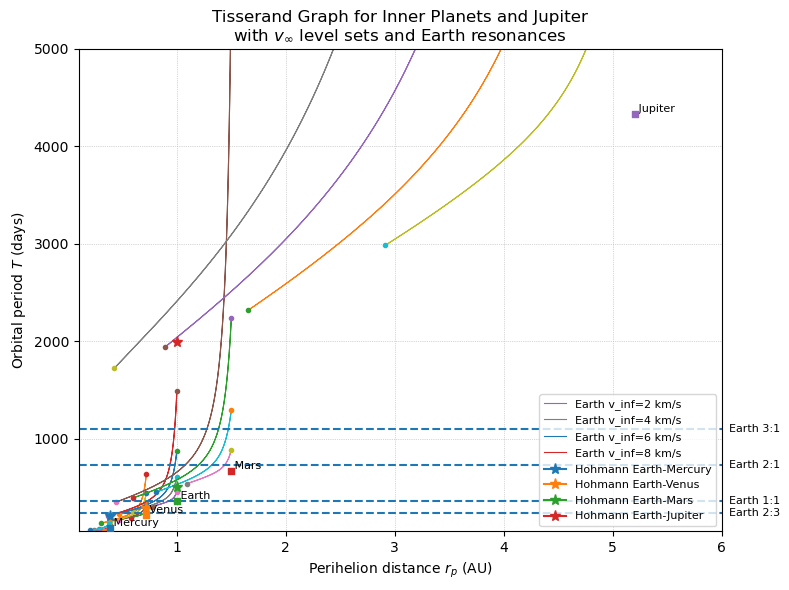

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --------------------------------------------------
# 1. Basic constants and planets
# --------------------------------------------------

AU = 150e6  # km (given in problem)

# Planet semimajor axes in AU (given)
a_mer_AU  = 0.39
a_ven_AU  = 0.72
a_earth_AU = 1.0
a_mars_AU = 1.5
a_jup_AU  = 5.2

planets_AU = {
    "Mercury": a_mer_AU,
    "Venus":   a_ven_AU,
    "Earth":   a_earth_AU,
    "Mars":    a_mars_AU,
    "Jupiter": a_jup_AU,
}

# Convert to km
planets_km = {name: a_AU * AU for name, a_AU in planets_AU.items()}

a_mer   = planets_km["Mercury"]
a_ven   = planets_km["Venus"]
a_earth = planets_km["Earth"]
a_mars  = planets_km["Mars"]
a_jup   = planets_km["Jupiter"]

# Choose mu_sun so that Earth's orbital period is exactly 1 sidereal year (365.25 days)
T_earth_days_target = 365.25
T_earth_sec_target = T_earth_days_target * 86400.0
mu_sun = 4 * math.pi**2 * a_earth**3 / T_earth_sec_target**2  # km^3/s^2

def period_from_a(a):
    """Orbital period (seconds) for semi-major axis a (km) around the Sun."""
    return 2 * math.pi * math.sqrt(a**3 / mu_sun)


# --------------------------------------------------
# 2. Hohmann v_inf from Earth to each planet (for checking)
# --------------------------------------------------

def v_inf_hohmann_from_earth(a_target):
    """
    Hohmann transfer from Earth (a_earth) to a_target (km).
    Returns Earth departure hyperbolic excess v_inf (km/s).
    """
    a_T = 0.5 * (a_earth + a_target)  # transfer orbit SMA
    v_trans = math.sqrt(mu_sun * (2.0 / a_earth - 1.0 / a_T))
    v_earth = math.sqrt(mu_sun / a_earth)
    return abs(v_trans - v_earth)

print("Hohmann v_inf at Earth (km/s):")
for name, a in [("Mercury", a_mer), ("Venus", a_ven),
                ("Mars", a_mars), ("Jupiter", a_jup)]:
    v_inf = v_inf_hohmann_from_earth(a)
    print(f"  Earth -> {name:7s}: {v_inf:6.3f} km/s")
print()


# --------------------------------------------------
# 3. v_inf level sets in (r_p, T) space
# --------------------------------------------------

def v_inf_level_set(a_p, v_inf, n_samples=400):
    """
    For a planet on a circular orbit of radius a_p (km), compute
    the set of heliocentric orbits that intersect that planet's orbit and
    have a given v_inf (km/s) relative to the planet.

    Returns arrays rp (km), T (s).
    """
    v_p = math.sqrt(mu_sun / a_p)

    deltas = np.linspace(0, 2*math.pi, n_samples)
    rp_list = []
    T_list = []

    for delta in deltas:
        # v_inf components: planet at (a_p,0), velocity along +y
        v_inf_x = v_inf * math.sin(delta)
        v_inf_y = v_inf * math.cos(delta)

        # heliocentric spacecraft velocity
        v_x = v_inf_x
        v_y = v_p + v_inf_y

        v2 = v_x**2 + v_y**2
        eps = 0.5 * v2 - mu_sun / a_p  # specific energy

        if eps >= 0:
            # unbound heliocentric orbit
            continue

        a = -mu_sun / (2 * eps)  # SMA
        v_t = v_y                # tangential component
        h = a_p * v_t            # angular momentum per unit mass

        e2 = 1 + 2 * eps * h**2 / mu_sun**2
        if e2 < 0:
            continue
        e = math.sqrt(e2)
        if e >= 1:
            continue

        rp = a * (1 - e)  # perihelion distance
        if rp <= 0:
            continue

        T = period_from_a(a)
        rp_list.append(rp)
        T_list.append(T)

    return np.array(rp_list), np.array(T_list)


def v_inf_level_set_with_markers(a_p, v_inf, n_samples=400):
    """
    Same as v_inf_level_set but also returns approximate "extreme" points
    on the curve (min and max T), to use as markers
    corresponding to max energy-change cases.
    """
    rp, T = v_inf_level_set(a_p, v_inf, n_samples)
    if len(rp) == 0:
        return rp, T, None, None

    i_min = int(np.argmin(T))
    i_max = int(np.argmax(T))

    p_min = (rp[i_min], T[i_min])
    p_max = (rp[i_max], T[i_max])

    return rp, T, p_min, p_max


# --------------------------------------------------
# 4. Build and plot the Tisserand graph
# --------------------------------------------------

v_inf_levels = [2.0, 4.0, 6.0, 8.0]  # km/s, adjust as desired

fig, ax = plt.subplots(figsize=(8, 6))

# For each planet, plot v_inf level sets
for name, a_p in planets_km.items():
    for v_inf in v_inf_levels:
        rp, T, p_min, p_max = v_inf_level_set_with_markers(a_p, v_inf)
        if len(rp) == 0:
            continue

        # v_inf curves
        ax.plot(rp / AU, T / 86400.0, linewidth=0.8,
                label=f"{name} v_inf={v_inf:.0f} km/s" if name == "Earth" else "")

        # Mark "extreme" points (approx max/min energy)
        if p_min is not None:
            ax.plot(p_min[0] / AU, p_min[1] / 86400.0,
                    marker="o", markersize=3)
        if p_max is not None:
            ax.plot(p_max[0] / AU, p_max[1] / 86400.0,
                    marker="o", markersize=3)

# Plot planet circular orbits as reference points
for name, a_p in planets_km.items():
    T_p = period_from_a(a_p)
    ax.scatter([a_p / AU], [T_p / 86400.0], marker="s", s=25, zorder=5)
    ax.text(a_p / AU, T_p / 86400.0, f" {name}", fontsize=8,
            ha="left", va="bottom")

# Earth resonant orbits (1:1, 2:1, 2:3, 3:1)
T_earth = period_from_a(a_earth)
resonances = {
    "1:1": 1.0 * T_earth,
    "2:1": 2.0 * T_earth,
    "2:3": (2.0 / 3.0) * T_earth,
    "3:1": 3.0 * T_earth,
}

rp_min_AU = 0.1
rp_max_AU = 6.0
for label, T_res in resonances.items():
    ax.hlines(T_res / 86400.0, rp_min_AU, rp_max_AU,
              linestyles="dashed")
    ax.text(rp_max_AU, T_res / 86400.0, f"  Earth {label}",
            fontsize=8, ha="left", va="center")

# Hohmann transfer orbits (Earth -> each other planet)
for name, a_target in [("Mercury", a_mer), ("Venus", a_ven),
                       ("Mars", a_mars), ("Jupiter", a_jup)]:
    a_T = 0.5 * (a_earth + a_target)
    T_T = period_from_a(a_T)
    # For a Hohmann between a1 and a2, rp is min(a1, a2)
    rp_H = min(a_earth, a_target)
    ax.plot(rp_H / AU, T_T / 86400.0, marker="*", markersize=8,
            label=f"Hohmann Earth-{name}")

# Labels and limits
ax.set_xlabel("Perihelion distance $r_p$ (AU)")
ax.set_ylabel("Orbital period $T$ (days)")
ax.set_title("Tisserand Graph for Inner Planets and Jupiter\n"
             "with $v_\\infty$ level sets and Earth resonances")
ax.set_xlim(0.1, 6.0)
ax.set_ylim(50, 5000)

# Only show one legend entry per type to avoid clutter
handles, labels = ax.get_legend_handles_labels()
# Quick dedup
seen = {}
new_handles = []
new_labels = []
for h, l in zip(handles, labels):
    if l not in seen:
        seen[l] = True
        new_handles.append(h)
        new_labels.append(l)
ax.legend(new_handles, new_labels, fontsize=8, loc="lower right")

ax.grid(True, which="both", linestyle=":", linewidth=0.5)

plt.tight_layout()
plt.show()